<a href="https://colab.research.google.com/github/Rapidsnopp/MNIST-CNN/blob/main/Bai_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [ ]:
def init_weight(shape, init = 'default', fan_in = None, fan_out = None):
  if init =='xavier':
    limit = np.sqrt(6/(fan_in + fan_out))
    return np.random.uniform(-limit, limit, shape)
  elif init == 'he':
    std = np.sqrt(2/fan_in)
    return np.random.randn(*shape) * std
  else:
    return np.random.randn(*shape) * 0.01

In [ ]:
def padding(x, padding: int | tuple | list, padding_type='zero'):
    assert padding_type in ['zero', 'reflect', 'edge', 'symmetric']
    if isinstance(padding, int):
        padding = (padding, padding)
    if padding_type == 'zero':
        return np.pad(x, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])),
                      'constant', constant_values=0)
    else:
        return np.pad(x, ((0, 0), (0, 0), (padding[0], padding[0]), (padding[1], padding[1])), padding_type)

def dilation(x, dilation: int | tuple | list):
    if isinstance(dilation, int):
        dilation = (dilation, dilation)
    if dilation == 0:
        return x
    size = x.shape
    h_out = size[2] + (size[2]-1) * dilation[0]
    w_out = size[3] + (size[3]-1) * dilation[1]
    out = np.zeros((size[0], size[1], h_out, w_out))
    pad = dilation[0] + 1
    for i in range(size[2]):
        for j in range(size[3]):
            out[:, :, i*pad, j*pad] = x[:, :, i, j]
    return out

In [ ]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size: int | list | tuple, stride=1, padding=0, padding_type='edge', is_bias=True):
        self.in_channels = in_channels
        self.out_channels = out_channels
        assert isinstance(kernel_size, (int, list, tuple))
        if isinstance(kernel_size, (tuple, list)):
            assert len(kernel_size) == 2
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.weights = np.random.randn(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1])
        self.bias = np.random.randn(out_channels) if is_bias else None
        self.padding_type = padding_type
        self.training = True
        self.input = None
        self.w_grad = None
        self.b_grad = None

    def forward(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, axis=0)
        x = padding(x, self.padding, self.padding_type)
        if self.training:
            self.input = x
        batch_size, in_channels, height, width = x.shape
        assert in_channels == self.in_channels
        out = self._calculate_conv2d(x, self.weights, self.bias)
        return out

    def _calculate_conv2d(self, x, kernel, bias=None):
        batch, in_channels, height, width = x.shape
        out_channels, _, k_h, k_w = kernel.shape

        out_height = (height - k_h) // self.stride + 1
        out_width = (width - k_w) // self.stride + 1

        size = [batch, out_channels, out_height, out_width]
        out = np.zeros(size)

        kernel = np.expand_dims(kernel, axis=0)
        input_exp = np.expand_dims(x, axis=1)

        kernel = np.repeat(kernel, repeats=size[0], axis=0)
        input_exp = np.repeat(input_exp, repeats=size[1], axis=1)

        for i in range(out_height):
            for j in range(out_width):
                h = i * self.stride
                w = j * self.stride
                out[:, :, i, j] = np.sum(input_exp[:, :, :, h:h+k_h, w:w+k_w] * kernel, axis=(-1, -2, -3))
        if bias is not None:
            bias = bias.reshape(1, self.out_channels, 1, 1)
            out += bias
        return out


    def backward(self, grad_output):
        assert self.input is not None
        x = np.transpose(self.input, (1, 0, 2, 3))
        kernel_back_w = np.transpose(grad_output, (1, 0, 2, 3))
        kernel_back_w = dilation(kernel_back_w, self.stride-1)
        w_grad = self._calculate_conv2d(x, kernel_back_w)
        w_grad = np.transpose(w_grad, (1, 0, 2, 3))
        b_grad = np.sum(grad_output, axis=(0, 2, 3))
        self.w_grad = w_grad
        self.b_grad = b_grad
        w = np.transpose(self.weights, (1, 0, 2, 3))
        dilation_out = dilation(grad_output, self.stride-1)
        padding_grad_output = padding(dilation_out, (w.shape[2]-1, w.shape[3]-1))
        grad_input = self._calculate_conv2d(padding_grad_output, w[:, :, ::-1, ::-1])
        if self.padding > 0:
            grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]
        return grad_input

    def update(self, lr):
        if self.w_grad is None or self.b_grad is None:
            return
        self.weights -= lr * self.w_grad
        if self.bias is not None:
            self.bias -= lr * self.b_grad

    def zero_grad(self):
        self.w_grad = None
        self.b_grad = None

    def eval(self):
        self.training = False

    def train(self):
        self.training = True

    def __call__(self, x):
        return self.forward(x)

In [ ]:
class MaxPool2d:
    def __init__(self, kernel_size: int | list | tuple, stride=2, padding=0, padding_type='edge'):
        if isinstance(kernel_size, (tuple, list)):
            assert len(kernel_size) == 2
            self.kernel_size = kernel_size
        else:
            self.kernel_size = (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.padding_type = padding_type
        self.input = None

    def forward(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, axis=0)
        x = padding(x, self.padding, self.padding_type)
        self.input = x
        out = self._calculate_maxpool2d(x)
        return out

    def _calculate_maxpool2d(self, x):
        batch, in_channels, height, width = x.shape
        out_height = (height - self.kernel_size[0]) // self.stride + 1
        out_width = (width - self.kernel_size[1]) // self.stride + 1
        size = [batch, in_channels, out_height, out_width]
        out = np.zeros(size)
        for i in range(out_height):
            for j in range(out_width):
                h = i * self.stride
                w = j * self.stride
                out[:, :, i, j] = np.max(x[:, :, h:h+self.kernel_size[0], w:w+self.kernel_size[1]], axis=(-1, -2))
        return out

    def backward(self, grad_output):
        assert self.input is not None
        x = self.input
        grad_input = np.zeros(x.shape)
        size = grad_output.shape
        for i in range(size[2]):
            for j in range(size[3]):
                h = i * self.stride
                w = j * self.stride
                x_slice = x[:, :, h:h+self.kernel_size[0], w:w+self.kernel_size[1]]
                max_val = np.max(x_slice, axis=(-1, -2), keepdims=True)
                mask = (x_slice == max_val).astype(int)
                grad = grad_output[:, :, i, j][:, :, None, None]
                grad_input[:, :, h:h+self.kernel_size[0], w:w+self.kernel_size[1]] += mask * grad
        if self.padding > 0:
            grad_input = grad_input[:, :, self.padding:-self.padding, self.padding:-self.padding]
        return grad_input

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

In [ ]:
class Linear:
    def __init__(self, in_channels, out_channels):
        self.w = np.random.randn(in_channels, out_channels) * 0.01
        self.b = np.zeros(out_channels)
        self.training = True
        self.input = None
        self.w_grad = None
        self.b_grad = None

    def forward(self, x):
        if self.training:
            self.input = x
        return np.dot(x, self.w) + self.b

    def backward(self, out_grad):
        x = self.input
        self.w_grad = np.dot(x.T, out_grad)
        self.b_grad = np.sum(out_grad, axis=0)
        return np.dot(out_grad, self.w.T)

    def update(self, lr):
        self.w -= lr * self.w_grad
        self.b -= lr * self.b_grad

    def zero_grad(self):
        self.w_grad = np.zeros_like(self.w)
        self.b_grad = np.zeros_like(self.b)

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        self.training = False

    def train(self):
        self.training = True

In [ ]:
# Sigmoid activation
class Sigmoid:
    def forward(self, x):
        self.input = x
        return 1 / (1 + np.exp(-x))

    def backward(self, out_grad):
        sig = self.forward(self.input)
        return out_grad * sig * (1 - sig)

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

# Tanh activattion
class Tanh:
  def forward(self, x):
    self.input = x
    return np.tanh(x)

  def backward(self, out_grad):
    tanh = self.forward(self.input)
    return out_grad * (1 - tanh**2)

  def update(self, lr):
    pass

  def zero_grad(self):
    pass

  def __call__(self, x):
    return self.forward(x)

  def eval(self):
    pass

  def train(self):
    pass

# ReLU activation
class ReLU:
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)

    def backward(self, out_grad):
        return out_grad * (self.input > 0)

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass
# Leaky ReLU activaation
class LeakyReLU:
    def __init__(self, alpha=0.1):
        self.alpha = alpha

    def forward(self, x):
        self.input = x
        return np.maximum(self.alpha*x, x)

    def backward(self, out_grad):
        return out_grad * (self.input > 0) + self.alpha * out_grad

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

# Maxout activation
class Maxout:

  def forward(self, x):
    self.input = x
    return np.max(x.reshape(x.shape[0], x.shape[1] // 2, 2, x.shape[2], x.shape[3]), axis=2)

  def backward(self, out_grad):
    return out_grad

  def update(self, lr):
    pass

  def zero_grad(self):
    pass

  def __call__(self, x):
    return self.forward(x)

  def eval(self):
    pass

  def train(self):
    pass


# ELU activation
class ELU:
  def __init__(self, alpha=0.1):
    self.alpha = alpha

  def forward(self, x):
    self.input = x
    return np.where(x > 0, x, self.alpha * (np.exp(x) - 1))

  def backward(self, out_grad):
    return np.where(self.input > 0, out_grad, out_grad * self.alpha * np.exp(self.input))

  def update(self, lr):
    pass

  def zero_grad(self):
    pass

  def __call__(self, x):
    return self.forward(x)

  def eval(self):
    pass

  def train(self):
    pass

In [ ]:
class CrossEntropyLoss:
    def forward(self, y_pred, y_true):
        # Đảm bảo y_pred không có giá trị quá 0
        y_pred = np.clip(y_pred, 1e-7, 1)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def backward(self, y_pred, y_true):
        # Khi kết hợp với softmax, đạo hàm của loss là (y_pred - y_true)
        return y_pred - y_true

    def __call__(self, y_pred, y_true):
        return self.forward(y_pred, y_true)

class SGD:
    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr

    def step(self):
        self.model.update(self.lr)

    def zero_grad(self):
        self.model.zero_grad()

In [ ]:
class Softmax:
    def forward(self, x):
        x = x - np.max(x, axis=1, keepdims=True)
        exp = np.exp(x)
        self.output = exp / np.sum(exp, axis=1, keepdims=True)
        return self.output

    def backward(self, y_pred, y_true):
        return y_pred - y_true

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

In [ ]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, grad_output):
        for layer in self.layers[::-1]:
            grad_output = layer.backward(grad_output)
        return grad_output

    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    def zero_grad(self):
        for layer in self.layers:
            layer.zero_grad()

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        for layer in self.layers:
            layer.eval()

    def train(self):
        for layer in self.layers:
            layer.train()

class Flatten:
    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, grad_output):
        return grad_output.reshape(self.input_shape)

    def update(self, lr):
        pass

    def zero_grad(self):
        pass

    def __call__(self, x):
        return self.forward(x)

    def eval(self):
        pass

    def train(self):
        pass

In [ ]:
class ResidualBlock:
    """
    Khối Residual gồm 2 lớp Conv2d với ReLU và thêm skip connection.
    Nếu số kênh của input và output không khớp, thực hiện phép chiếu (projection).
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, padding_type='edge'):
        self.conv1 = Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_type)
        self.relu1 = ReLU()
        self.conv2 = Conv2d(out_channels, out_channels, kernel_size, 1, padding, padding_type)
        self.relu2 = ReLU()
        # Nếu số kênh không khớp hoặc stride khác 1, dùng projection
        if in_channels != out_channels or stride != 1:
            self.proj = Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, padding_type=padding_type)
        else:
            self.proj = None
        # Lưu lại các giá trị cần dùng cho backward
        self.add = None
        self.input = None

    def forward(self, x):
        self.input = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        if self.proj is not None:
            identity = self.proj(x)
        else:
            identity = x
        self.add = out + identity
        out = self.relu2(self.add)
        return out

    def backward(self, grad_output):
        # Backward qua ReLU cuối cùng
        grad_relu2 = grad_output * (self.add > 0)
        # Tách gradient cho 2 nhánh: qua conv2 và qua skip connection
        grad_conv2 = grad_relu2.copy()
        grad_identity = grad_relu2.copy()
        grad_conv2 = self.conv2.backward(grad_conv2)
        grad_conv2 = self.relu1.backward(grad_conv2)
        grad_conv2 = self.conv1.backward(grad_conv2)
        if self.proj is not None:
            grad_identity = self.proj.backward(grad_identity)
        grad_input = grad_conv2 + grad_identity
        return grad_input

    def update(self, lr):
        self.conv1.update(lr)
        self.conv2.update(lr)
        if self.proj is not None:
            self.proj.update(lr)

    def zero_grad(self):
        self.conv1.zero_grad()
        self.conv2.zero_grad()
        if self.proj is not None:
            self.proj.zero_grad()

    def eval(self):
        self.conv1.eval()
        self.conv2.eval()
        if self.proj is not None:
            self.proj.eval()

    def train(self):
        self.conv1.train()
        self.conv2.train()
        if self.proj is not None:
            self.proj.train()

    def __call__(self, x):
        return self.forward(x)


In [ ]:
class MNISTModel:
    def __init__(self, in_channels, nums_classes, size, cfg=None):
        self.conv_layer, out_size = self._make_conv_layer(in_channels, size, cfg)
        self.fc_layer = self._make_fc_layer(out_size, nums_classes)
        self.softmax = Softmax()

    def _make_conv_layer(self, in_channels, size, cfg=None):
        # Nếu không có cấu hình, chỉ trả về đầu vào ban đầu
        if cfg is None:
            return None, (in_channels, size[0], size[1])
        scale = 1
        conv_layer = []
        for layer in cfg:
            if isinstance(layer, (list, tuple)):
                # Cấu hình dạng [out_channels, kernel_size, stride, padding]
                conv_layer.append(Conv2d(in_channels, layer[0], layer[1], layer[2], layer[3]))
                in_channels = layer[0]
            elif isinstance(layer, str):
                if layer == 'M':
                    conv_layer.append(MaxPool2d(2, 2))
                    scale *= 2
                # Sử dụng 'Res' để đánh dấu ResidualBlock (skip connection)
                elif layer in ['R', 'Res']:
                    conv_layer.append(ResidualBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
        return Sequential(conv_layer), (in_channels, size[0] // scale, size[1] // scale)

    def _make_fc_layer(self, out_size, nums_classes):
        return Sequential([
            Flatten(),
            Linear(out_size[0] * out_size[1] * out_size[2], nums_classes),
        ])

    def forward(self, x):
        if self.conv_layer is not None:
            x = self.conv_layer(x)
        x = self.fc_layer(x)
        x = self.softmax(x)
        return x

    def backward(self, y_pred, y_true):
        grad_output = y_pred - y_true
        grad_output = self.fc_layer.backward(grad_output)
        if self.conv_layer is not None:
            grad_output = self.conv_layer.backward(grad_output)
        return grad_output

    def __call__(self, x):
        return self.forward(x)

    def update(self, lr):
        if self.conv_layer is not None:
            self.conv_layer.update(lr)
        self.fc_layer.update(lr)

    def zero_grad(self):
        if self.conv_layer is not None:
            self.conv_layer.zero_grad()
        self.fc_layer.zero_grad()

    def eval(self):
        if self.conv_layer is not None:
            self.conv_layer.eval()
        self.fc_layer.eval()

    def train(self):
        if self.conv_layer is not None:
            self.conv_layer.train()
        self.fc_layer.train()

In [ ]:
class MNISTDataset:
    def __init__(self, X, y):
        self.X = X.reshape(-1, 1, 28, 28)
        self.y = self._convert_to_one_hot(y)

    def __len__(self):
        return len(self.X)

    def _convert_to_one_hot(self, y):
        one_hot = np.zeros((len(y), 10))
        one_hot[np.arange(len(y)), y.astype(int)] = 1
        return one_hot

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class Dataloader:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.n_batches = len(dataset) // batch_size
        if len(dataset) % batch_size != 0:
            self.n_batches += 1

    def __iter__(self):
        for i in range(self.n_batches):
            batch_X = self.dataset.X[i*self.batch_size : (i+1)*self.batch_size]
            batch_y = self.dataset.y[i*self.batch_size : (i+1)*self.batch_size]
            yield batch_X, batch_y

    def __len__(self):
        return self.n_batches


Epoch 1/5 | Train Loss: 0.6727 | Val Loss: 0.3585
Epoch 2/5 | Train Loss: 0.3059 | Val Loss: 0.2898
Epoch 3/5 | Train Loss: 0.2551 | Val Loss: 0.2521
Epoch 4/5 | Train Loss: 0.2255 | Val Loss: 0.2279
Epoch 5/5 | Train Loss: 0.2058 | Val Loss: 0.2116


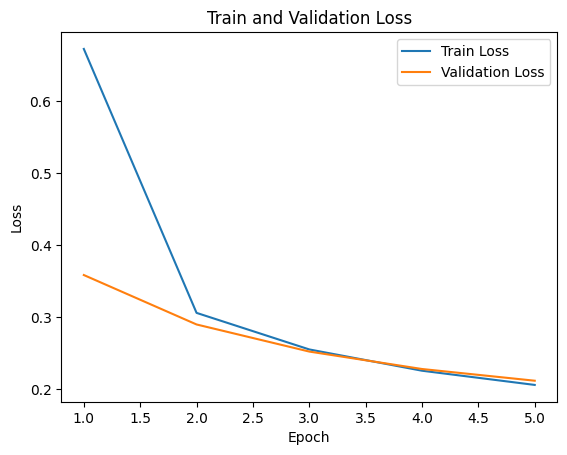

Test Accuracy: 0.9423571428571429


In [ ]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target
X = X.to_numpy().astype(np.float32) / 255.0
y = y.to_numpy()

# Chia dữ liệu thành train/validation/test (tương đương 64%/16%/20% của toàn bộ dữ liệu)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)

train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)
test_dataset = MNISTDataset(X_test, y_test)

# Cấu hình mạng với skip connection: ban đầu Conv2d, sau đó ResidualBlock, rồi MaxPool2d
cfg = [
    [4, 3, 1, 1],
    'ReLU',    # ResidualBlock với skip connection
    'M',
]

# Khởi tạo dataloader cho train và validation
train_dataloader = Dataloader(train_dataset, 64)
val_dataloader = Dataloader(val_dataset, 64)

model = MNISTModel(1, 10, (28, 28), cfg)
loss_fn = CrossEntropyLoss()
optimizer = SGD(model, 0.00001)

EPOCHS = 5
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Huấn luyện trên tập train
    if hasattr(model, 'train'):
        model.train()  # Nếu model có phương thức train() thì chuyển sang chế độ training
    epoch_train_losses = []
    for batch_X, batch_y in train_dataloader:
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y)
        model.backward(y_pred, batch_y)
        optimizer.step()
        optimizer.zero_grad()
        epoch_train_losses.append(loss)
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # Đánh giá trên tập validation
    if hasattr(model, 'eval'):
        model.eval()   # Chuyển model sang chế độ eval để không ảnh hưởng bởi dropout, batchnorm,...
    epoch_val_losses = []
    for batch_X, batch_y in val_dataloader:
        y_pred_val = model(batch_X)
        loss_val = loss_fn(y_pred_val, batch_y)
        epoch_val_losses.append(loss_val)
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')

# Vẽ đồ thị loss của cả tập train và validation
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

# Đánh giá trên tập test
if hasattr(model, 'eval'):
    model.eval()
y_pred = model(X_test.reshape(-1, 1, 28, 28))
y_pred = np.argmax(y_pred, axis=1)
y_test = np.array(y_test).astype(int)
print("Test Accuracy:", np.mean(y_pred == y_test))
